# Snownlp Training 
- Using 5,000,000 Weibo Corpus
-  link: http://www.nlpir.org/wordpress/2018/01/26/500%E4%B8%87%E5%BE%AE%E5%8D%9A%E8%AF%AD%E6%96%99/

In [ ]:
## import packages
import re
from snownlp import sentiment
import numpy as np
import pandas as pd
import pymysql
from snownlp import SnowNLP
from snownlp import sentiment
from snownlp.sentiment import Sentiment
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('ggplot')
import time

In [ ]:
## connect to SQL database server
conn = pymysql.connect(host='localhost', user='root', password='******', charset="utf8",use_unicode=False)
with conn:
    cur = conn.cursor()
    cur.execute("SELECT * FROM test.weibo WHERE weiboId < '%d'" % 5000000)
    rows = cur.fetchall()

In [ ]:
## transform all text to list
comment = []
for row in rows:
    row = list(row)
    comment.append(row[18])

In [ ]:
## cleaning & model traning
## notice that if snownlp classify corpus as extreme positive (>0.8), it will be classified as positive
## if snownlp classfify corpus as extreme negative (<0.3), it will be classified as negative
def train_model(texts):
    for li in tqdm(texts):
        comm = li.decode('utf-8')
        text = re.sub(r'(?:回复)?(?://)?@[\w\u2E80-\u9FFF]+:?|\[\w+\]', ',',comm)
        score = SnowNLP(text)
        if score.sentiments > 0.8:
            with open('pos.txt', mode='a', encoding='utf-8') as g:
                g.writelines(comm +"\n")
        elif score.sentiments < 0.3:
            with open('neg.txt', mode='a', encoding='utf-8') as f:
                f.writelines(comm + "\n")
        else:
            pass

In [ ]:
## train all comments and get pos.txt & neg.txt
%%time
train_model(comment)

In [ ]:
## retrain the bayes model embedded in snownlp package and save it
%%time
sentiment.train('neg.txt', 'pos.txt')
sentiment.save('sentiment.marshal') 

# Apply ReTrained Model
- use the newly trained sentiment.marshal as model
- ues jieba package to replace the word splitting process in snownlp

In [1]:
import jieba

In [2]:
df = pd.read_csv('df_final.csv',encoding='utf-8')
df = df[(df.content != '转发微博')&(df.content != 'repost')&(df.content != '')]
df = df.dropna()
df = df.reset_index(drop=True)

In [3]:
df.head()

,user_id,created_at,content,like_num,repost_num,comment_num
0,1681872675,2020-01-20 08:10,发现满屏都是关于新冠肺炎在全国各地传播的新闻，虽可控可防，但还是觉得可怕，不禁想起09年非典...,0,0,0
1,1306052985,2020-01-20 08:21,三条通报的时间点好一致//首发症状大多为发热、咳嗽、胸闷、呼吸困难，这新冠肺炎还挺厉害的……,0,0,0
2,2218332387,2020-01-20 09:08,关于最近很猖狂的新冠型肺炎病毒 我们紧急召开了第二届家庭会议 与会人员：我、谢胖子 会议主题...,0,1,3
3,2167644005,2020-01-20 13:49,有过上海世博会的经历，各种排队不是个事儿。有过非典型肺炎的经验，武汉新冠也不会恐慌。,0,0,0
4,7339096067,2020-01-20 18:34,#星座[超话]# 仔细想想，自打1.12土冥合相之后就没什么好消息啊…叹气 更不用说这两天突...,4,0,7


In [4]:
df['sentiment'] = ''

In [5]:
df.shape

(36655, 7)

In [ ]:
%%time
for i in range(df.shape[0]):
    comm = df.content[i]
    text = re.sub(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)','',comm)
    text = re.sub(r'(?:回复)?(?://)?@[\w\u2E80-\u9FFF]+:?|\[\w+\]', ',',text)
    r='[’！？：；【】，、《》!"#$%&\'()（）“”…*+,-./:;<=>?@[\\]^_`{|}~]+'
    text = re.sub(r, '', text)
    if text:
        s = SnowNLP(text)
        df['sentiment'][i] = s.sentiments
    else:
        df['sentiment'][i] = 0.5

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\asus\AppData\Local\Temp\jieba.cache
Loading model cost 0.732 seconds.
Prefix dict has been built successfully.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


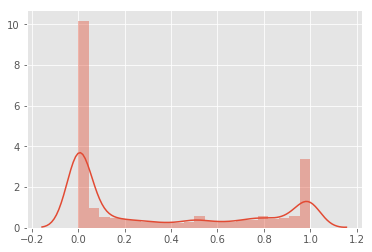

In [24]:
senti = df.sentiment.tolist()
ax = sns.distplot(senti)

In [29]:
df.to_csv('retrain_data.csv')